In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Загрузка и обработка данных

In [2]:
data = pd.read_csv("athletes.csv")
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [4]:
data[ pd.isnull( data['height'] ) ].count()

id             330
name           330
nationality    330
sex            330
dob            329
height           0
weight          21
sport          330
gold           330
silver         330
bronze         330
dtype: int64

In [5]:
data[ pd.isnull( data['weight'] ) ].count()

id             659
name           659
nationality    659
sex            659
dob            658
height         350
weight           0
sport          659
gold           659
silver         659
bronze         659
dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()

le.fit(data["sex"])
le.classes_

array(['female', 'male'], dtype=object)

In [8]:
le.transform(['female', 'male'])

array([0, 1])

In [9]:
data["sex"] = pd.Series(le.transform(data["sex"]))
data[ pd.isnull( data['sex'] ) ].count()

id             0
name           0
nationality    0
sex            0
dob            0
height         0
weight         0
sport          0
gold           0
silver         0
bronze         0
dtype: int64

In [10]:
data = data[~(data.isnull().any(axis=1))]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  int32  
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 975.5+ KB


# Построение графиков для выявления зависимостей

<Axes: >

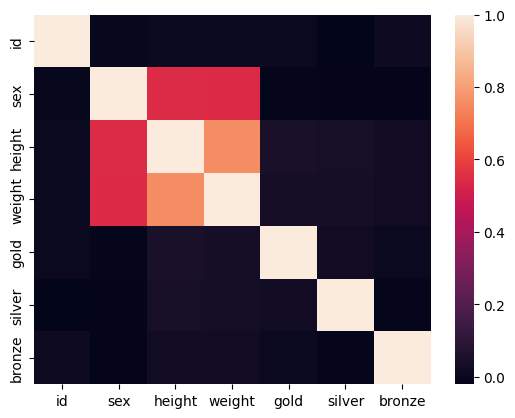

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sns.heatmap(data.select_dtypes(include=numerics).corr())

Реально коррелируются только признаки height и weight. Остальные брать не нужно. Категориальные же данные смысла не несут тоже, так как никаким образом не влияют на определение пола человека.

# Разделение на X и Y, Обучение Логистической регрессии

In [12]:
X = data[['height', 'weight']]
X.head()

,height,weight
0,1.72,64.0
1,1.68,56.0
2,1.98,79.0
3,1.83,80.0
4,1.81,71.0


In [13]:
Y = data["sex"]
Y.head()

0    1
1    0
2    1
3    1
4    1
Name: sex, dtype: int32

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train) + len(X_test) == len(X)

True

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

prediction_Y = model.predict_proba(X_test)[::,1]

In [16]:
model.score(X_train, Y_train)

0.7736587612249597

In [17]:
model.score(X_test, Y_test)

0.7767034990791897

# Оценка модели

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test, prediction_Y)
len(thresholds)

790

In [19]:
import matplotlib.pyplot as plt

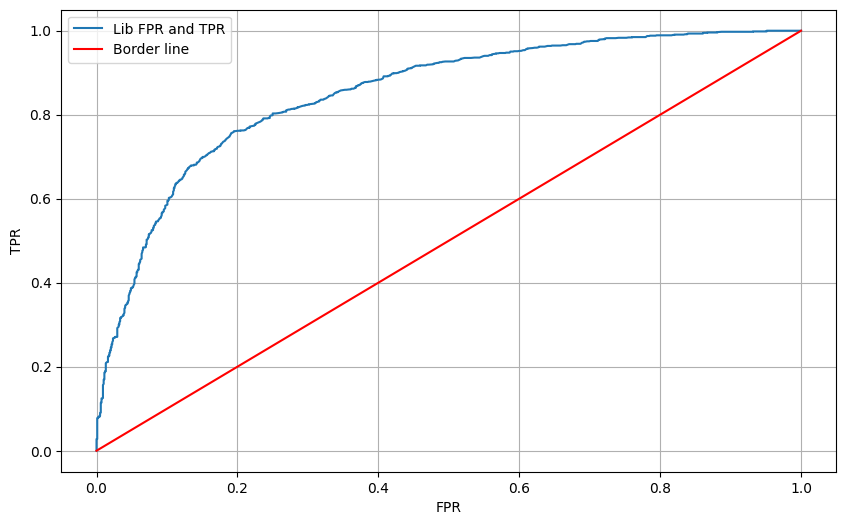

In [30]:
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label="Lib FPR and TPR")
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color="red", label="Border line")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, prediction_Y)

0.8505357607237688

# Собственная реализация метрик

In [22]:
def my_roc_curve(prediction_Y, Y_test, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        tp, fp, fn, tn = (0, 0, 0, 0)
        for predicted_prob, actual in zip(prediction_Y, Y_test):
            if predicted_prob >= threshold:
                if actual == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if actual == 1:
                    fn += 1
                else:
                    tn += 1
        cur_tpr = tp / (tp + fn)
        tpr.append(cur_tpr)
        cur_fpr = fp / (fp + tn)
        fpr.append(cur_fpr)
    return tpr, fpr

my_tpr, my_fpr = my_roc_curve(prediction_Y, Y_test, thresholds)
print(len(my_tpr), len(my_fpr))

790 790


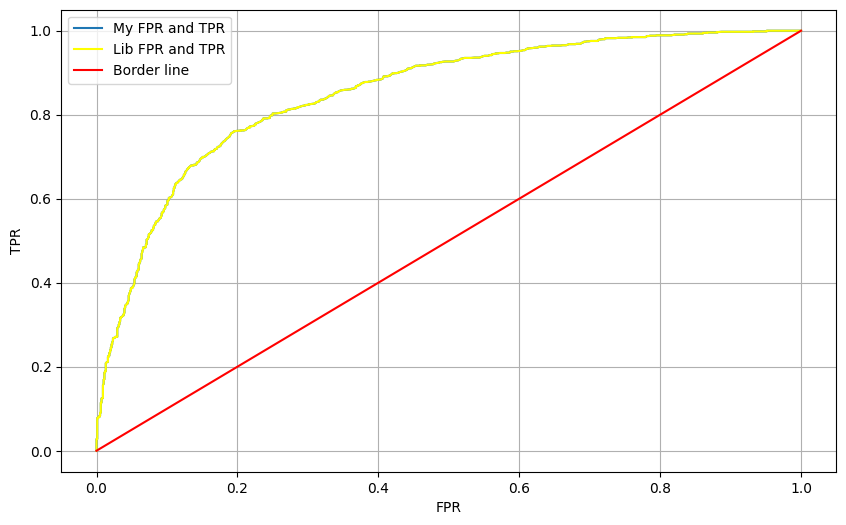

In [31]:
plt.figure(figsize=(10,6))
plt.plot(my_fpr, my_tpr, label="My FPR and TPR")
plt.plot(fpr, tpr, color="yellow", label="Lib FPR and TPR")
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color="red", label="Border line")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()

Мой график и график, посторенный с помощью функции roc_curve - идентичны. Это означает, что я смог в точности повторить этот довольно простой алгоритм функции.

In [24]:
def my_precision_recall_curve(prediction_Y, Y_test, thresholds):
    precision = []
    recall = []
    for threshold in thresholds:
        tp, fp, fn, tn = (0, 0, 0, 0)
        for predicted_prob, actual in zip(prediction_Y, Y_test):
            if predicted_prob >= threshold:
                if actual == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if actual == 1:
                    fn += 1
                else:
                    tn += 1
        if (tp + fp) > 0 and (tp + fn) > 0:
            cur_precision = tp / (tp + fp)
            precision.append(cur_precision)
            cur_recall = tp / (tp + fn)
            recall.append(cur_recall)
    return precision, recall

my_precision, my_recall = my_precision_recall_curve(prediction_Y, Y_test, thresholds)
print(len(my_precision), len(my_recall))

789 789


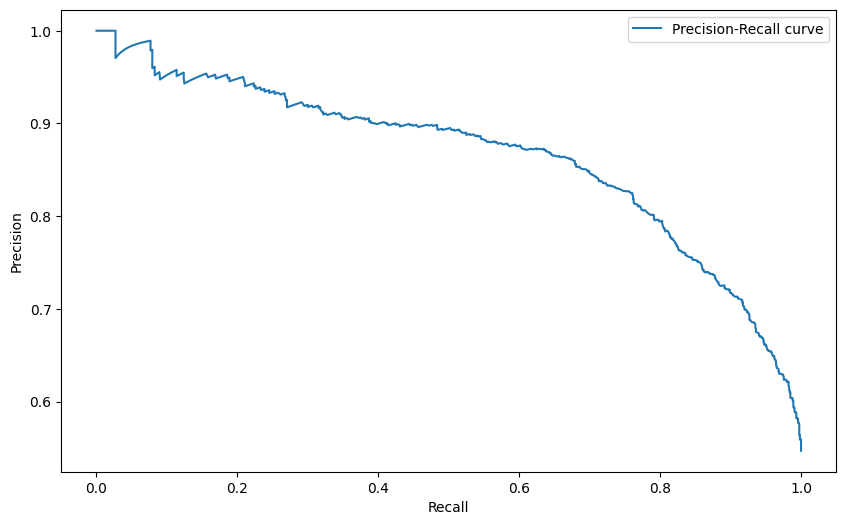

In [32]:
plt.figure(figsize=(10,6))
plt.plot(my_recall, my_precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [26]:
roc_auc_manual = np.trapz(my_tpr, my_fpr)
print('ROC-AUC (manual):', roc_auc_manual)

ROC-AUC (manual): 0.8505357607237688


# Вывод
    Оценка ROC-AUC является простой в использовании, эффективной, но не очень интуитивно понятной. В любом слачае модель довольно неплохо справилась со своей задачей, но, конечно, если бы были преобразования данных (например, нормализация) или выбор другой модели, то площадь под графиком была бы ещё больше. 
    Может ли ROC-кривая проходить ниже диагонали? Ответ - да, если модель предсказывает классы хуже, чем случайно (то есть в большенстве случаев класс 1 - это 0 класс для модели и наоборот). Но это очень специфичный случай, так как никто нам не мешает поменять местами ответы модели - то есть все 0 превратить в 1 и наоборот.